### Import dependencies

In [3]:
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import shapiro
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
import optuna
import seaborn as sns
import numpy as np
import torch

Reading ```xlsx``` files into memory

In [4]:
train = pd.read_excel("train.xlsx")
test = pd.read_excel("test.xlsx")

Drop unnamed columns just in case

In [5]:
for col in [train, test]:
    col.drop(columns="Unnamed: 0")

Getting rid of the columns where 90%+ of values are empty

In [6]:
columns_to_erase = [col for col in train.columns if train[col].isna().mean() > 0.9]
for col in [train, test]:
    col.drop(columns=columns_to_erase)

Workaround to fill tutor_rating & tutor_reviews columns

In [7]:
dataframes = [train, test]
for df in dataframes:
    for col in ['tutor_rating', 'tutor_reviews']:
        df[col] = df[col].fillna(train[col].median())
    df['experience'] = pd.to_numeric(df['experience'].str.split().str[0], errors='coerce')
    df['experience'] = df['experience'].fillna(train['experience'].median()).astype(int)



Histograms of ```expirience``` in train & test data 





array([[<Axes: title={'center': 'experience'}>]], dtype=object)

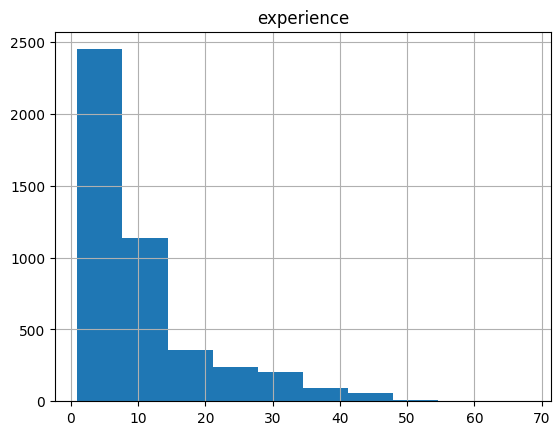

In [8]:
train.hist('experience')

array([[<Axes: title={'center': 'experience'}>]], dtype=object)

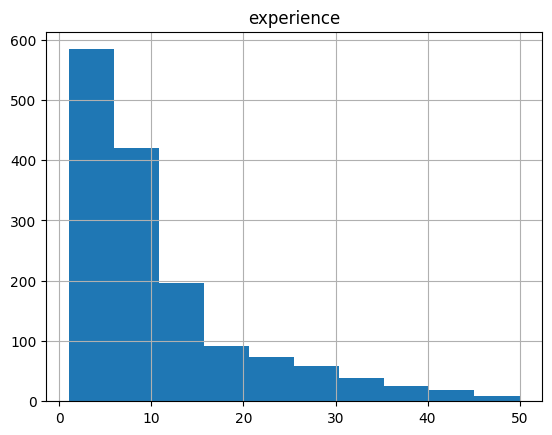

In [9]:
test.hist('experience')

The feature is distributed with exponential decay and the distributions on the train and test are similar and the outliers are insignificant

array([[<Axes: title={'center': 'tutor_reviews'}>]], dtype=object)

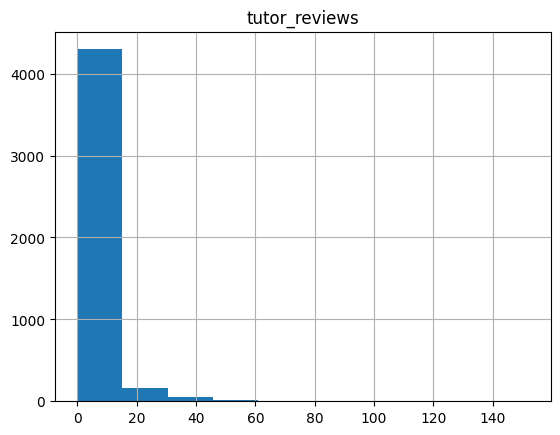

In [10]:
train.hist('tutor_reviews')

array([[<Axes: title={'center': 'tutor_reviews'}>]], dtype=object)

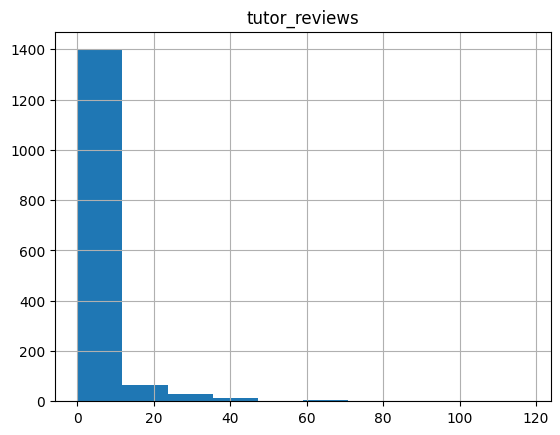

In [11]:
test.hist('tutor_reviews')

There's a long tail in the distribution of this feature. ```Train``` and ```test``` data distributions are almost identical

array([[<Axes: title={'center': 'tutor_rating'}>]], dtype=object)

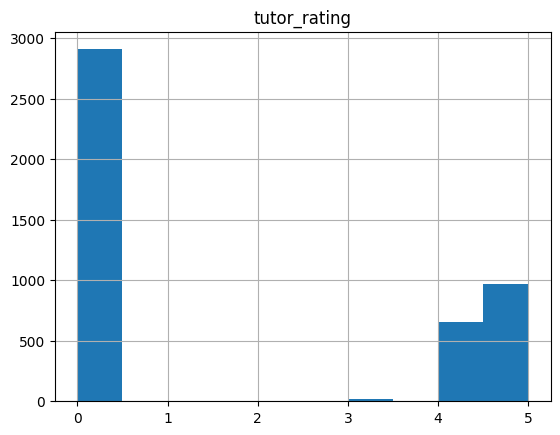

In [12]:
train.hist('tutor_rating')

array([[<Axes: title={'center': 'tutor_rating'}>]], dtype=object)

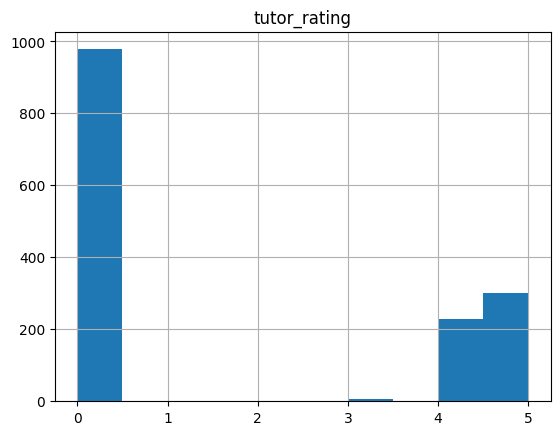

In [13]:
test.hist('tutor_rating')

Similar site as the previous one

Now, let’s take all the text information from our data, including columns such as descriptions, titles, and tags, and process it through Bag of Words (BOW) and TruncatedSVD to extract meaningful features. In addition to the features generated by these techniques, we can also add more features such as the lengths of these texts to capture additional information about the data

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

text_cols = ['tutor_head_tags', 'description', 'experience_desc', 'Education_1', 'Desc_Education_1', 'Education_2', 'Desc_Education_2', 'status', 'categories']

for df in [train, test]:
    # Fill missing values with a placeholder string
    df[text_cols] = df[text_cols].fillna('Пусто')
    
    # Calculate the length of text in each column
    for col in text_cols:
        df[f'{col}_len'] = df[col].str.len()
    
    # Concatenate the text from all columns into a single column
    df['all_text'] = df[text_cols].apply(lambda x: ' '.join(x), axis=1)

# Create a TfidfVectorizer and fit it on the training data
vectorizer = TfidfVectorizer()
vectorizer.fit(train['all_text'])

# Transform the text in both DataFrames
train_vectors = vectorizer.transform(train['all_text'])
test_vectors = vectorizer.transform(test['all_text'])

# Create a PCA object and fit it on the training data
pca = PCA(n_components=25)
pca.fit(train_vectors.toarray())

# Apply dimensionality reduction to both DataFrames
train_reduced = pca.transform(train_vectors.toarray())
test_reduced = pca.transform(test_vectors.toarray())

# Add the reduced vectors as new columns in the DataFrames
for i in range(train_reduced.shape[1]):
    train[f'v_{i}'] = train_reduced[:, i]
    test[f'v_{i}'] = test_reduced[:, i]



Let’s test the hypothesis that the distribution of the mean_price column is normal using Shapiro-Wilk test. It is a statistical test used to determine if a sample of data comes from a normally distributed population.

In [15]:
shapiro(train['mean_price'])

ShapiroResult(statistic=0.9175645709037781, pvalue=2.1019476964872256e-44)

Shapiro value is small enough so hypothesis is incorrect

Second hypothesis - teachers with better ratings get better price rate

In [16]:
train['tutor_rating'].corr(train['mean_price'])

0.11329923669674874

Correlation value is very close to 0 so there's almost no linear dependence

Now, let's test the third hypothesis, teachers with more experience have a higher price per minute

In [17]:
train['experience'].corr(train['mean_price'])

0.13358053504701928

Correlation value is very close to 0 so there's almost no linear dependence

Now let's check if teachers with higher amount of tutor_reviews per year ```(tutor_reviews/experience)``` get better price per minute 

In [23]:
train['reviews_experience_ratio'] = train['tutor_reviews'] / train['experience']

# Calculate the correlation between the ratio and mean_price
correlation = train['reviews_experience_ratio'].corr(train['mean_price'])

print(f'Correlation between reviews/experience ratio and mean price: {correlation}')

Correlation between reviews/experience ratio and mean price: 0.0965310146495654


Again, correlation value is very close to 0 so there's almost no linear dependence

Now, save the files to use them in TRAIN file

In [24]:
train.to_csv('train.csv', index=None)
test.to_csv('test.csv', index=None)